In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [3]:
df = pd.read_csv('../beforecovid.csv')
df["Year"] = df["Date"].str.split("-").str[2]

In [4]:
df["Year"].value_counts()

19    4842
17    3447
18    3369
20    1804
Name: Year, dtype: int64

In [5]:
df_assigned = df

In [6]:
df_assigned = df_assigned.reset_index(drop=True)
df_assigned

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"['mine', '20', 'years', 'resale', 'flat', 'top...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"['kimurayuki', 'mine', '20', 'years', 'resale'...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"['punggolbto', 'per', 'actual', 'hdb', 'models...",punggolbto per actual hdb models floor plans p...,2019-01-18
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"['purchased', 'resale', 'flat', 'recently', 'w...",purchased resale flat recently without agent u...,2018-10-19
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"['add', 'go', 'hdb', 'website', 'check', 'rece...",add go hdb website check recent 6mths resale t...,2018-10-20
...,...,...,...,...,...,...,...
13457,12-Oct-19,Van Holland Former Toho Mansion Holland Villag...,19,Oct,"['van', 'holland', 'former', 'toho', 'mansion'...",van holland former toho mansion holland villag...,2019-10-12
13458,13-Oct-19,Another project:\nFinal 15 units of T.O.P Read...,19,Oct,"['another', 'project', 'final', '15', 'units',...",another project final 15 units p ready boutiqu...,2019-10-13
13459,13-Oct-19,Zetrio2006 said:\nAnother project:\nFinal 15 u...,19,Oct,"['zetrio2006', 'another', 'project', 'final', ...",zetrio2006 another project final 15 units p re...,2019-10-13
13460,13-Oct-19,bolster said:\nWow... did you try walking to t...,19,Oct,"['bolster', 'wow', 'try', 'walking', 'holland'...",bolster wow try walking holland v mrt really 5...,2019-10-13


# Data cleaning

In [7]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", (x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use','r']
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))

# create bigram
def make_bigrams(texts):
    texts = ["_".join(w) for w in ngrams(texts, 2)]
    return texts

data_words = df_assigned["clean_text"].tolist()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: make_bigrams(x))

In [8]:
# avoided lemmatization for bigram as the results are more interesting without generating words like 4rooms within1km which are not included in the allowed postags
# lemmatization
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     texts_out = []
#     print(texts[0])
#     doc = nlp(' '.join(str(v) for v in texts)) 
#     for token in doc:
#         if token.pos_ in allowed_postags:
#             texts_out.append(token.lemma_)

#     return texts_out

# df_assigned['clean_text'] = df_assigned['clean_text'].head().apply(lambda x: lemmatization(x))

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    try:
        description_str += ' '.join(row for row in word_list) + ' '
    except:
        print(word_list)

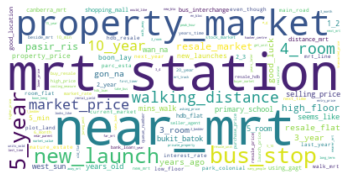

In [29]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("bigram_wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




NameError: name 'sns' is not defined

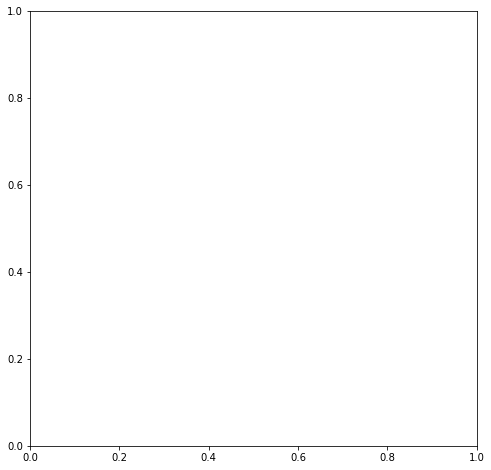

In [30]:
new_tokens = []
for i in df_assigned["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [11]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[1:3])

[['kimurayuki_mine', 'mine_20', '20_years', 'years_resale', 'resale_flat', 'flat_top', 'top_1999', '1999_got', 'got_bomb', 'bomb_shelter', 'shelter_aircon', 'aircon_ledge', 'ledge_noise', 'noise_external', 'external_traffic', 'traffic_supermarket', 'supermarket_loading', 'loading_bay', 'bay_well', 'well_mine', 'mine_7', '7_8', '8_years', 'years_old', 'old_resales', 'resales_flat', 'flat_yes', 'yes_home', 'home_heard', 'heard_traffic', 'traffic_besides', 'besides_busy', 'busy_road', 'road_traffic', 'traffic_noise', 'noise_sleep', 'sleep_w', 'w_aircon', 'aircon_noise', 'noise_neighbour', 'neighbour_made', 'made_slammed', 'slammed_doors', 'doors_sometime', 'sometime_1', '1_2am', '2am_sometimes', 'sometimes_things', 'things_dropped', 'dropped_2', '2_3am', '3am_think', 'think_timing', 'timing_quiet', 'quiet_time', 'time_normal', 'normal_ppl', 'ppl_sleep', 'sleep_haiz', 'haiz_spore', 'spore_shld', 'shld_law', 'law_inconsiderate', 'inconsiderate_neighbours'], ['punggolbto_per', 'per_actual', 

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)]]


In [13]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, '1999_got'), (1, '20_years'), (2, '5_years'), (3, 'aircon_ledge'), (4, 'bay_crazyclubx'), (5, 'bomb_shelter'), (6, 'bought_punggol'), (7, 'buy_wait'), (8, 'change_buy'), (9, 'clearly_heard'), (10, 'crazyclubx_last'), (11, 'doors_clearly'), (12, 'doors_haiz'), (13, 'end_peace'), (14, 'external_traffic'), (15, 'flat_top'), (16, 'forever_least'), (17, 'got_bomb'), (18, 'haiz_end'), (19, 'haiz_noisy'), (20, 'hdb_stayed'), (21, 'hear_noise'), (22, 'heard_hdb'), (23, 'home_haiz'), (24, 'house_thought'), (25, 'inconsiderate_upstairs'), (26, 'knew_rather'), (27, 'last_time'), (28, 'least_change'), (29, 'ledge_noise'), (30, 'loading_bay'), (31, 'mine_20'), (32, 'move_slamming'), (33, 'neighbours_pain'), (34, 'noise_external'), (35, 'noise_slamming'), (36, 'noisy_inconsiderate'), (37, 'peace_knew'), (38, 'punggol_house'), (39, 'rather_rent'), (40, 'rent_forever'), (41, 'rent_unfortunately'), (42, 'resale_flat'), (43, 'sell_move'), (44, 'shelter_aircon'), (45, 's

## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [14]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [15]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3310213152738657
Perplexity Score:  -11.20229231479119

topic number:  3
Coherence Score:  0.3121601264409876
Perplexity Score:  -11.11458058485873

topic number:  4
Coherence Score:  0.3835148868478858
Perplexity Score:  -11.02357351405432

topic number:  5
Coherence Score:  0.4066543741279737
Perplexity Score:  -10.970059126703836

topic number:  6
Coherence Score:  0.4012125913637378
Perplexity Score:  -10.967038136486101

topic number:  7
Coherence Score:  0.439427128250439
Perplexity Score:  -10.99184745984115

topic number:  8
Coherence Score:  0.4672299481541387
Perplexity Score:  -11.149360485193519

topic number:  9
Coherence Score:  0.5231526235386202
Perplexity Score:  -11.678387664262594

topic number:  10
Coherence Score:  0.47586470167881173
Perplexity Score:  -12.80376786140429

topic number:  11
Coherence Score:  0.5098317371915644
Perplexity Score:  -14.785996887284917

topic number:  12
Coherence Score:  0.5232077221196347
Perplexi

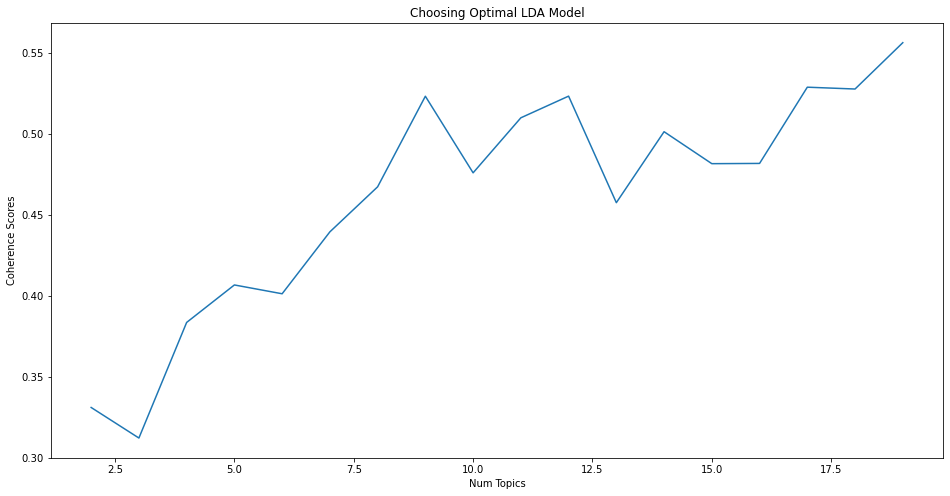

In [16]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [17]:
ntopics_des_name = 10

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [18]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.008*"bukit_batok" + 0.005*"located_right" + 0.005*"new_development" + '
  '0.005*"per_cent" + 0.004*"sell_units" + 0.004*"fixed_rate" + '
  '0.003*"upper_serangoon" + 0.003*"good_bad" + 0.002*"nan_hua" + '
  '0.002*"2nd_floor"'),
 (1,
  '0.005*"parc_esta" + 0.004*"may_know" + 0.003*"nassim_road" + '
  '0.003*"near_future" + 0.003*"property_market" + 0.003*"property_prices" + '
  '0.003*"aljunied_mrt" + 0.002*"new_launch" + 0.002*"prices_measured" + '
  '0.002*"3_years"'),
 (2,
  '0.004*"boon_lay" + 0.003*"walking_distance" + 0.003*"right_next" + '
  '0.002*"mrt_station" + 0.002*"much_better" + 0.002*"distance_mrt" + '
  '0.002*"min_walk" + 0.002*"mrt_amenities" + 0.002*"kent_ridge" + '
  '0.002*"dairy_farm"'),
 (3,
  '0.004*"per_plot" + 0.003*"grandeur_park" + 0.003*"high_park" + '
  '0.003*"unsold_units" + 0.003*"end_day" + 0.002*"hdb_gov" + '
  '0.002*"green_line" + 0.002*"distance_away" + 0.002*"pool_view" + '
  '0.002*"gov_sg"'),
 (4,
  '0.010*"using_gagt" + 0.005*"new_mr

In [19]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [20]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [21]:
df_assigned['Topic'] = topic_num

In [22]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

,Date,text,clean_text,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...","[mine_20, 20_years, years_resale, resale_flat,...",[8]
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,"[kimurayuki_mine, mine_20, 20_years, years_res...",[8]
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,"[punggolbto_per, per_actual, actual_hdb, hdb_m...",[2]
3,19-Oct-18,I have just purchased a resale flat recently w...,"[purchased_resale, resale_flat, flat_recently,...",[5]
4,20-Oct-18,"Just to add, go to hdb website and check recen...","[add_go, go_hdb, hdb_website, website_check, c...",[6]


In [23]:
# des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [24]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -12.841383895213184
Coherence Score:  0.49660641881053547


## Visualisation

In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.370018  0.032391       1        1  31.858086
5     -0.052319  0.061339       2        1  10.762117
2     -0.000693 -0.286270       3        1  10.376457
9     -0.045673  0.173377       4        1  10.366219
7     -0.033403 -0.003962       5        1   7.698720
1     -0.053130  0.014705       6        1   7.194373
8     -0.043370 -0.005119       7        1   6.814413
4     -0.042957 -0.002282       8        1   5.526031
3     -0.045091  0.014199       9        1   5.131425
0     -0.053381  0.001622      10        1   4.272158, topic_info=                     Term        Freq       Total Category  logprob  loglift
8371            pasir_ris  880.000000  880.000000  Default  30.0000  30.0000
28443          using_gagt  309.000000  309.000000  Default  29.0000  29.0000
17152  central_residences  351.000000  351.000000  Default  28.0000  28.0000
25590              4_room  441.000000  441.000000  Default  27.0000  27.0000
2548           new_launch  701.000000  701.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
2074     businesstimes_sg   37.246753   59.148154  Topic10  -6.5076   2.6906
2342     cooling_measures   43.705896  155.699747  Topic10  -6.3477   1.8826
3301      property_market   48.290484  739.292093  Topic10  -6.2480   0.4246
4080            last_year   37.055931  276.099543  Topic10  -6.5128   1.1447
548        interest_rates   33.605900  142.215035  Topic10  -6.6105   1.7104

[500 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
16257      2  0.147041      10_20
16257      5  0.833233      10_20
35157      3  0.987469     10_min
677        1  0.322436   10_years
677        2  0.052972   10_years
...      ...       ...        ...
102        4  0.045142  years_old
102        7  0.006019  years_old
102        8  0.003009  years_old
23836      9  0.965297  yrs_lease
55592      1  0.990901    yrs_old

[884 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 10, 8, 2, 9, 5, 4, 1])

## Word Count of Topic Keywords

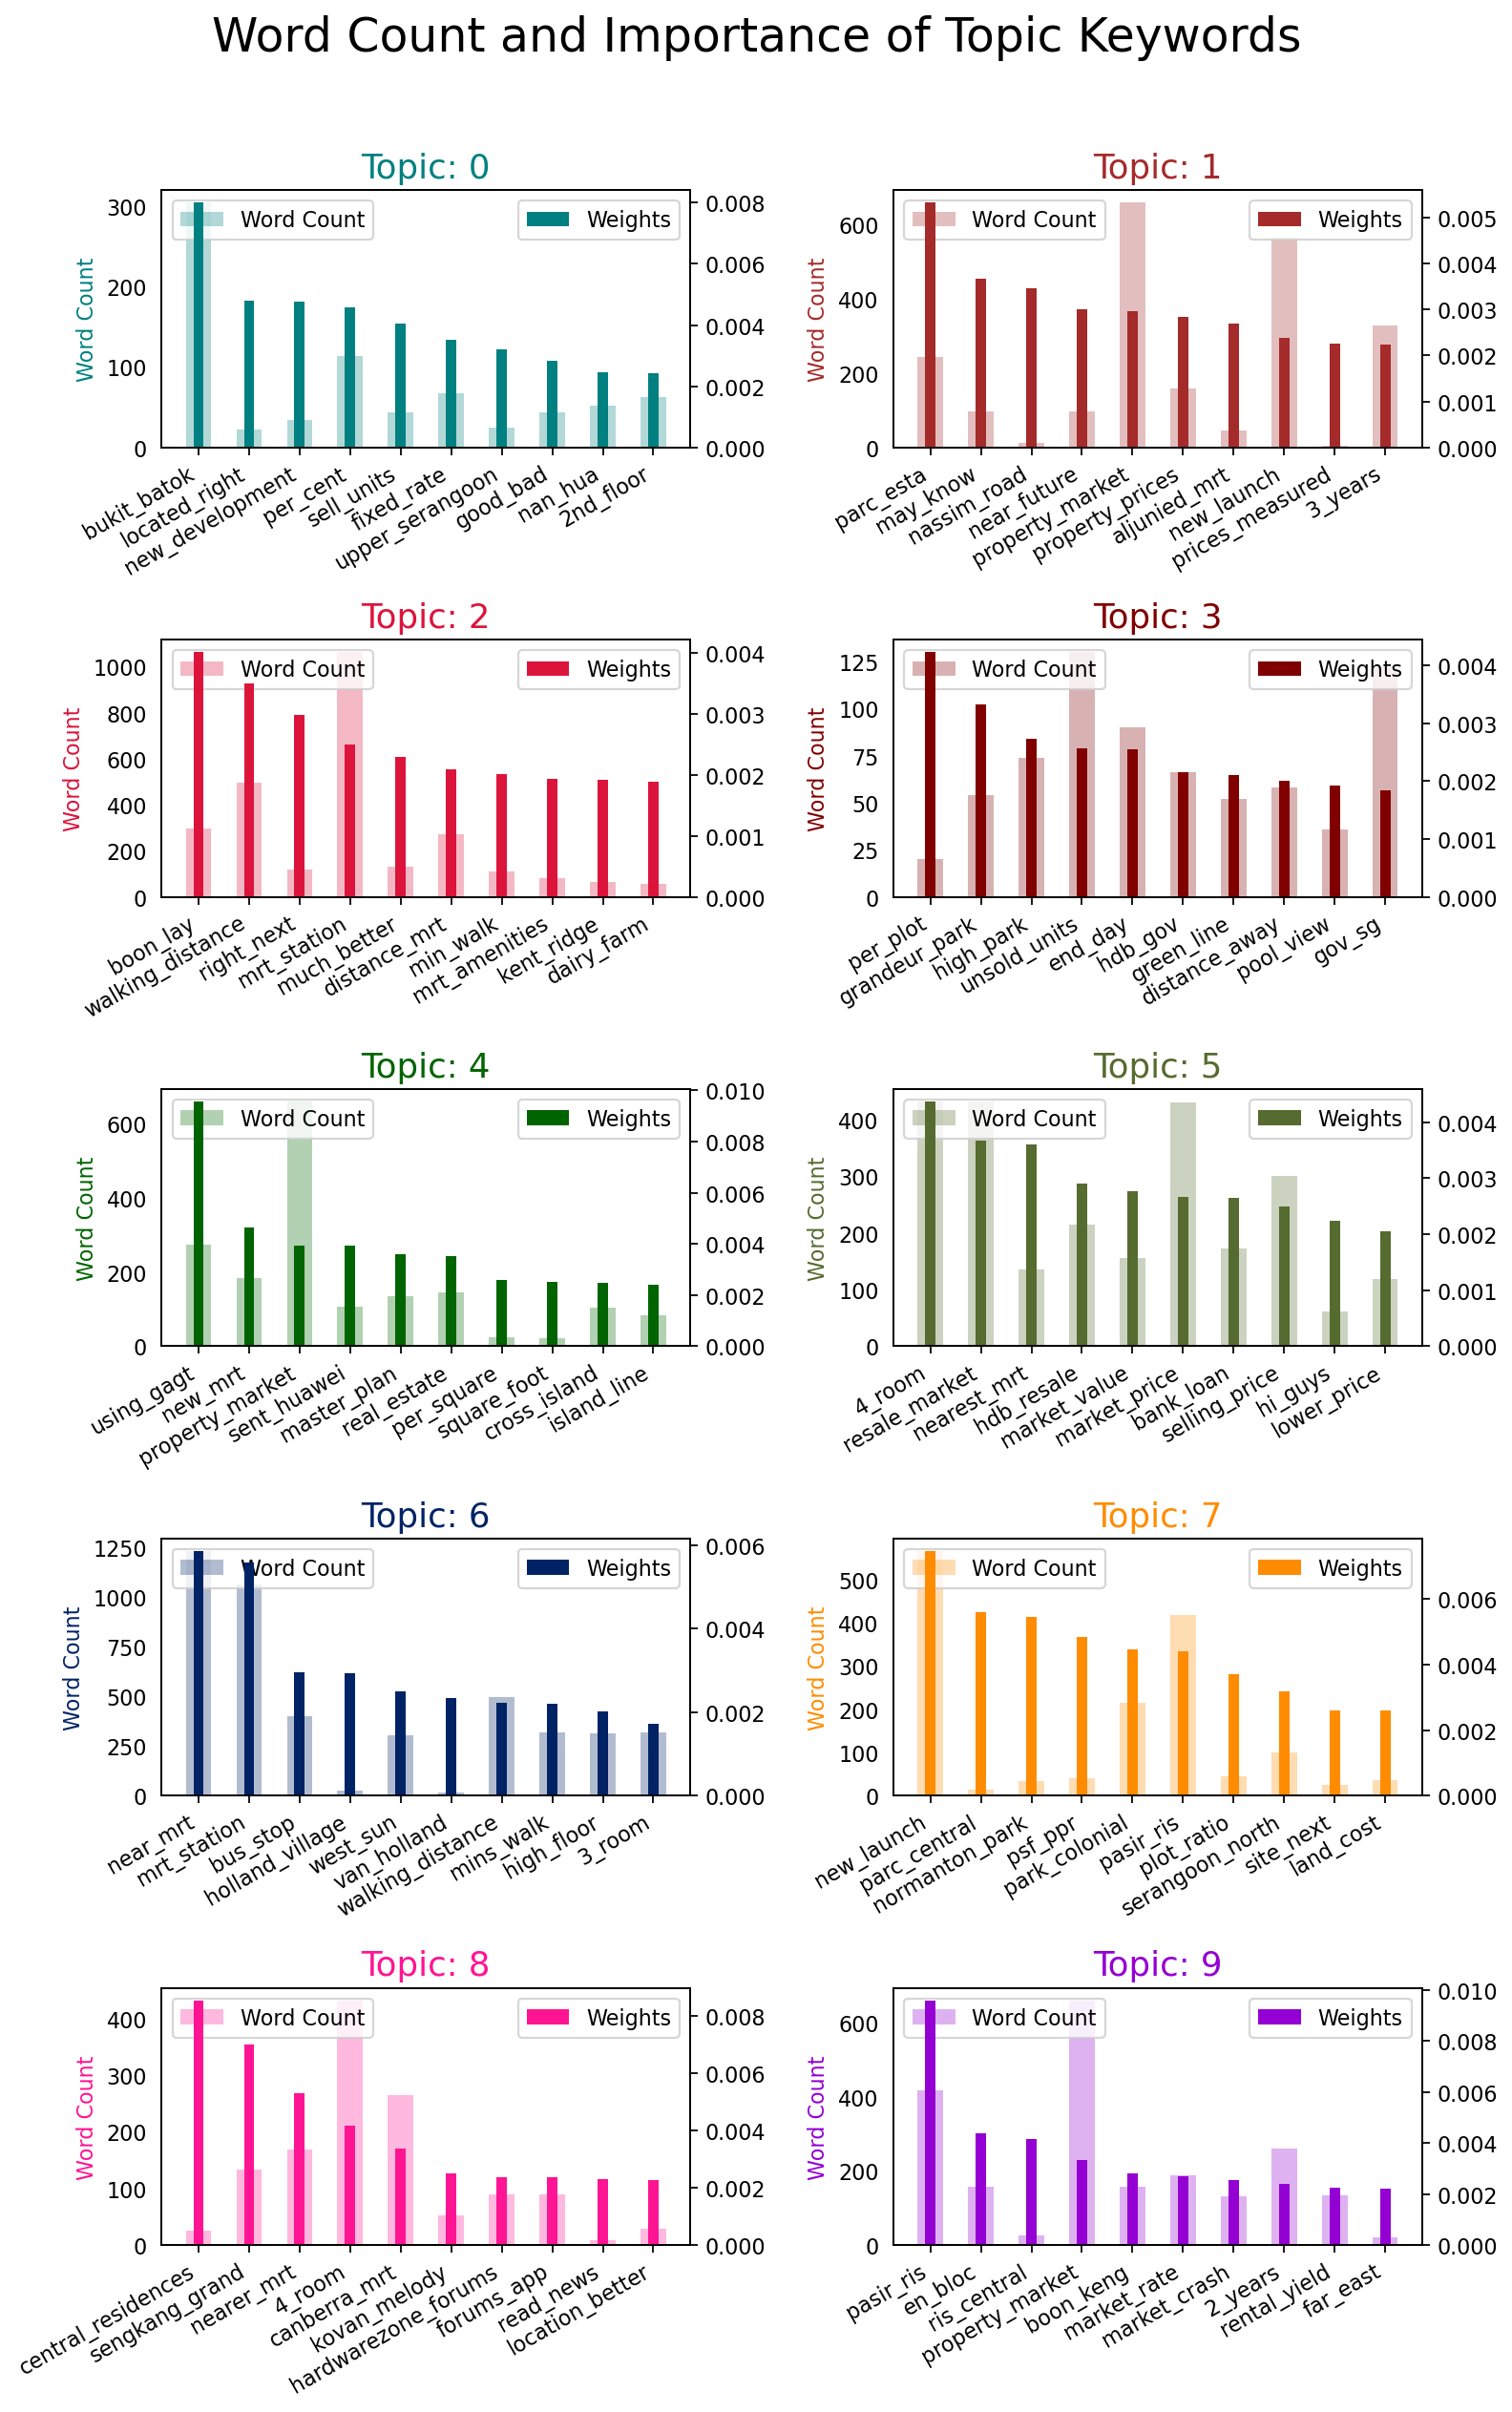

In [31]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('bigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
